# Определение перспективного тарифа для телеком компании

Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег: «Смарт» или «Ультра».
Так как задача - сравнить, то нам нет смысла выгружать все данные, мы можем провести оценку по случайным выборкам. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Описание тарифов

<b>Тариф «Смарт»</b>  
Ежемесячная плата: 550 рублей  
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика  
Стоимость услуг сверх тарифного пакета:  
минута разговора: 3 рубля  
сообщение: 3 рубля  
1 Гб интернет-трафика: 200 рублей  
<b>Тариф «Ультра»</b>  
Ежемесячная плата: 1950 рублей  
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика  
Стоимость услуг сверх тарифного пакета:  
минута разговора: 1 рубль  
сообщение: 1 рубль  
1 Гб интернет-трафика: 150 рублей  
***
<b>Обратите внимание:</b>  
«Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

## Просмотр первичных данных
Откроем данные и проанализируем их структуру.

In [1]:
import pandas as pd
from scipy import stats as st
import numpy as np

In [2]:
calls_df = pd.read_csv('/datasets/calls.csv')
internet_df = pd.read_csv('/datasets/internet.csv')
messages_df = pd.read_csv('/datasets/messages.csv')
tariffs_df = pd.read_csv('/datasets/tariffs.csv')
users_df = pd.read_csv('/datasets/users.csv')

In [3]:
calls_df.info()
calls_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [4]:
internet_df.info()
internet_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [5]:
messages_df.info()
messages_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [6]:
tariffs_df

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [7]:
users_df.info()
users_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Мы имеем данные на 500 абонентов. Их звонки, количество смс и интернет трафик. В данных нет пропусков, кроме даты прекращения пользования тарифом. Проведем первичный анализ данных и подготовку к оценке прибыльности.

## Подготовка данных

### Пользователи

Проверим наличие повторяющихся абонентов.

In [8]:
users_df.duplicated().sum()

0

Одинаковых абонетов нет. Приведем данные к нужным типам.

In [9]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [10]:
users_df['churn_date'] = pd.to_datetime(users_df['churn_date'], format='%Y-%m-%d')
users_df['reg_date'] = pd.to_datetime(users_df['reg_date'], format='%Y-%m-%d')

In [11]:
users_df.nunique()

user_id       500
age            58
churn_date     33
city           76
first_name    246
last_name     419
reg_date      270
tariff          2
dtype: int64

### Сообщения

Переведем данные к нужному типу.

In [12]:
messages_df['message_date'] = pd.to_datetime(messages_df['message_date'],format='%Y-%m-%d')

In [13]:
messages_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


Посчитаем количество отправленных сообщений для каждого пользователя по месяцам и в целом.

In [14]:
messages_per_month = messages_df.pivot_table(
    index = 'user_id',
    columns = messages_df['message_date'].dt.month,
    values='message_date',
    aggfunc='count',
    dropna=False
).fillna(0).astype('int')

In [15]:
messages_per_month.columns = ['jan','feb','mar','apr','may','jun','jul','aug','sep','okt','nov','dec']

In [16]:
messages_per_month['sum'] = messages_per_month.sum(axis=1)

In [17]:
messages_per_month

,jan,feb,mar,apr,may,jun,jul,aug,sep,okt,nov,dec,sum
user_id,,,,,,,,,,,,,
1000,0,0,0,0,22,60,75,81,57,73,58,70,496
1002,0,0,0,0,0,4,11,13,4,10,16,12,70
1003,0,0,0,0,0,0,0,37,91,83,94,75,380
1004,0,0,0,0,95,134,181,151,146,165,158,162,1192
1005,7,38,56,41,42,47,56,64,52,44,51,54,552
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0,0,0,0,0,0,0,13,82,82,79,84,340
1496,9,45,46,49,40,35,42,41,29,35,46,51,468
1497,0,0,0,0,0,0,0,0,0,20,14,17,51


По количеству строк можем сделать вывод, что не для всех абонентов есть данные по смс или не все их отправляли.

### Интернет трафик  
Изменение типов данных.

In [18]:
internet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [19]:
internet_df['session_date'] = pd.to_datetime(internet_df['session_date'],format='%Y-%m-%d')

Проверим есть ли выбросы.

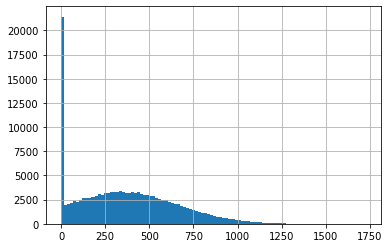

In [20]:
internet_df['mb_used'].hist(bins=100)

В районе 0 однозначно есть выброс. Посмотрим их внимательнее.

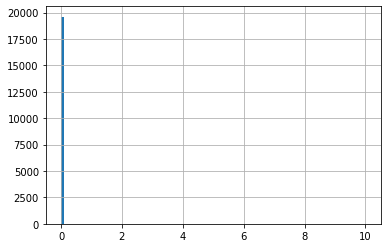

In [21]:
internet_df['mb_used'].hist(bins=100,range=(0,10))

In [22]:
internet_df[internet_df['mb_used'] == 0 ]

,Unnamed: 0,id,mb_used,session_date,user_id
11,11,1000_11,0.0,2018-08-28,1000
38,38,1000_38,0.0,2018-11-27,1000
46,46,1000_46,0.0,2018-06-30,1000
67,67,1000_67,0.0,2018-06-16,1000
72,72,1000_72,0.0,2018-06-15,1000
...,...,...,...,...,...
149380,149380,1499_141,0.0,2018-12-11,1499
149381,149381,1499_142,0.0,2018-11-01,1499
149383,149383,1499_144,0.0,2018-11-27,1499
149386,149386,1499_147,0.0,2018-10-21,1499


Почти 20 тысяч сессий имеют нулевой трафик. Они не представляют интерес для статистики. Уберем длинный хвост больших значений.

In [23]:
internet_df1 = internet_df.query('mb_used != 0')

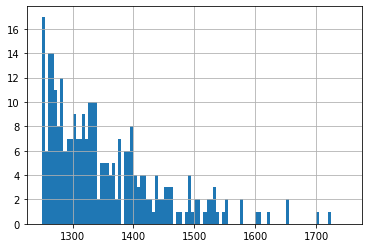

In [24]:
internet_df1['mb_used'].hist(bins=100,range=(1250,1750))

In [25]:
internet_df1 = internet_df.query('mb_used != 0 and mb_used < 1300')

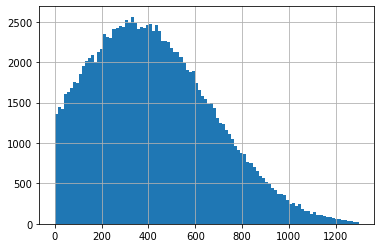

In [26]:
internet_df1['mb_used'].hist(bins=100)

Распределение похоже на нормальное, но смещено влево.    
Посчитаем количество тарфика для каждого пользователя по месяцам, округлив значения до целых гигабайт. Посчитаем весь трафик для каждого пользователя.

In [27]:
mb_per_month = (internet_df1.pivot_table(
    index = 'user_id',
    columns = internet_df1['session_date'].dt.month,
    values='mb_used',
    aggfunc='sum',
    dropna=False
).fillna(0) / 1024).apply(np.ceil).astype('int') * 1024 #округление до целых гигабайт

In [28]:
mb_per_month.columns = ['jan','feb','mar','apr','may','jun','jul','aug','sep','okt','nov','dec']

In [29]:
mb_per_month['sum'] = mb_per_month.sum(axis=1)

In [30]:
mb_per_month

,jan,feb,mar,apr,may,jun,jul,aug,sep,okt,nov,dec,sum
user_id,,,,,,,,,,,,,
1000,0,0,0,0,3072,23552,14336,14336,15360,15360,14336,10240,110592
1001,0,0,0,0,0,0,0,0,0,0,18432,14336,32768
1002,0,0,0,0,0,11264,18432,20480,17408,14336,19456,18432,119808
1003,0,0,0,0,0,0,0,9216,13312,14336,12288,10240,59392
1004,0,0,0,0,14336,18432,22528,27648,15360,19456,16384,18432,152576
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0,0,0,0,0,0,0,3072,33792,29696,39936,23552,130048
1496,4096,28672,25600,21504,24576,20480,24576,23552,27648,28672,25600,21504,276480
1497,0,0,0,0,0,0,0,0,0,12288,14336,20480,47104


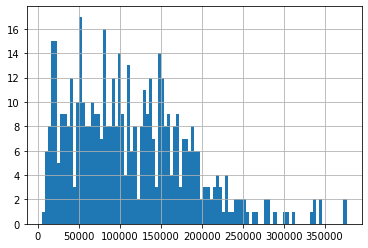

In [31]:
mb_per_month['sum'].hist(bins=100)

In [32]:
internet_df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129604 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      129604 non-null int64
id              129604 non-null object
mb_used         129604 non-null float64
session_date    129604 non-null datetime64[ns]
user_id         129604 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.9+ MB


Не все абоненты использовали интернет, судя по количеству строк. 

### Звонки  
Приведем данные к нужным типам.

In [33]:
calls_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [34]:
calls_df['call_date'] = pd.to_datetime(
    calls_df['call_date'], format='%Y-%m-%d'
)

Посмотрим длительность звонков на наличие выбросов.

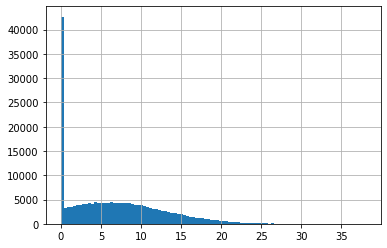

In [35]:
calls_df['duration'].hist(bins=100)

Нулевые значения - пропущенные звонки. Опустим их, так как они не вносят вклад в трату минут. Также опустим звонки дольше 25 минут.

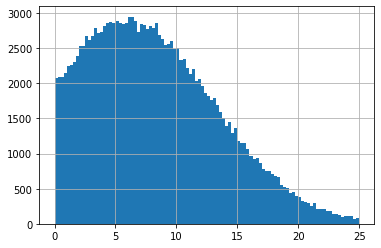

In [36]:
calls_df1 = calls_df.query('duration > 0 and duration < 25')

calls_df1['duration'].hist(bins=100)

Создадим таблицы для длительности звонков и количества звонков в месяц.

In [37]:
users_df['user_id']

0      1000
1      1001
2      1002
3      1003
4      1004
       ... 
495    1495
496    1496
497    1497
498    1498
499    1499
Name: user_id, Length: 500, dtype: int64

In [38]:
calls_count_per_month = calls_df1.pivot_table(
    index = 'user_id',
    columns = calls_df1['call_date'].dt.month,
    values='duration',
    aggfunc= 'count',
    dropna=False
).fillna(0).astype('int')#количество звонков

In [39]:
try:
    calls_count_per_month.columns =['jan','feb','mar','apr','may','jun','jul','aug','sep','okt','nov','dec']
    calls_count_per_month['sum'] = calls_count_per_month.sum(axis=1)
except:
    print('Функции уже выполнены')

In [40]:
calls_count_per_month

,jan,feb,mar,apr,may,jun,jul,aug,sep,okt,nov,dec,sum
user_id,,,,,,,,,,,,,
1000,0,0,0,0,17,28,41,42,46,44,37,38,293
1001,0,0,0,0,0,0,0,0,0,0,45,47,92
1002,0,0,0,0,0,14,20,37,25,24,25,27,172
1003,0,0,0,0,0,0,0,43,105,97,94,88,427
1004,0,0,0,0,7,25,20,18,18,21,15,15,139
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0,0,0,0,0,0,0,13,95,126,112,120,466
1496,6,65,67,52,50,57,63,62,58,55,66,65,666
1497,0,0,0,0,0,0,0,0,0,49,48,58,155


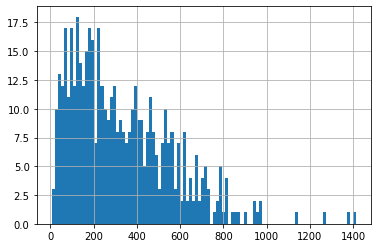

In [41]:
calls_count_per_month['sum'].hist(bins=100)

In [42]:
minute_per_month = calls_df1.pivot_table(
    index = 'user_id',
    columns = calls_df1['call_date'].dt.month,
    values='duration',
    aggfunc= 'sum',
    dropna=False
).fillna(0).apply(np.ceil).astype('int')#длительность звонков

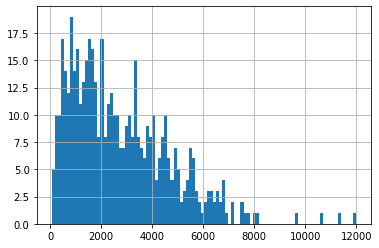

In [43]:
minute_per_month.columns = ['jan','feb','mar','apr','may','jun','jul','aug','sep','okt','nov','dec']
minute_per_month['sum'] = minute_per_month.sum(axis=1)

minute_per_month['sum'].hist(bins=100)

### Расчет помесячной выручки с каждого пользователя  
Рассчитаем прибыль от каждого абонента, исходя из предыдущих данных.

In [44]:
users_df

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaT,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaT,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaT,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


In [45]:
gain_per_month = users_df[['user_id','tariff']]

In [46]:
def gain(row):
    minuts = row['minuts']
    mb = row['mb']
    messages = row['messages']
    
    if row['reg_date'].month > month_index:
        return 0
    if row['churn_date'].month < month_index:
        return 0
    
    if row["tariff"] == 'ultra':
        tariff = tariffs_df.query('tariff_name == "ultra"').reset_index()
    else:
        tariff = tariffs_df.query('tariff_name == "smart"')
        
    gain = tariff.loc[0,'rub_monthly_fee']
    
    if minuts > tariff.loc[0,'minutes_included'].item():
        gain += (minuts - tariff.loc[0,'minutes_included']) * tariff.loc[0,'rub_per_minute']

    if messages > tariff.loc[0,'messages_included']:
        gain += (messages - tariff.loc[0,'messages_included']) * tariff.loc[0,'rub_per_message']
        
    if mb >  tariff.loc[0,'mb_per_month_included']:
        gain += (mb - tariff.loc[0,'mb_per_month_included']) * tariff.loc[0,'rub_per_gb'] / 1024
        
    return gain.round(1)

In [47]:
month_index = 1
for mon in ['jan','feb','mar','apr','may','jun','jul','aug','sep','okt','nov','dec']:
    
    month = pd.DataFrame(data = minute_per_month[mon],index = users_df['user_id'])
    month.columns = ['minuts']
    month['mb'] = mb_per_month[mon]
    month['messages'] = messages_per_month[mon]
    
    month = month.fillna(0).reset_index()
    month['tariff'] = users_df['tariff'].reindex_like(users_df['user_id'])
    month['reg_date'] = users_df['reg_date'].reindex_like(users_df['user_id'])
    month['churn_date'] = users_df['churn_date'].reindex_like(users_df['user_id'])
    
    gain_per_month[mon] = month.apply(gain,axis=1)
    month_index += 1
    
    
gain_per_month['sum'] = gain_per_month.loc[:,'jan':'dec'].sum(axis=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [48]:
gain_per_month

,user_id,tariff,jan,feb,mar,apr,may,jun,jul,aug,sep,okt,nov,dec,sum
0,1000,ultra,0.0,0.0,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,15600.0
1,1001,smart,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1150.0,550.0,1700.0
2,1002,smart,0.0,0.0,0.0,0.0,0.0,550.0,1150.0,1550.0,950.0,550.0,1350.0,1150.0,7250.0
3,1003,ultra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.0,9750.0
4,1004,ultra,0.0,0.0,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,15600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495,ultra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1950.0,2400.0,1950.0,3300.0,1950.0,11550.0
496,1496,smart,550.0,3336.0,2616.0,1750.0,2350.0,1640.0,2503.0,2150.0,2950.0,3150.0,2952.0,1753.0,27700.0
497,1497,smart,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,550.0,550.0,1598.0,2698.0
498,1498,smart,0.0,0.0,0.0,0.0,0.0,0.0,550.0,2386.0,1950.0,1750.0,0.0,0.0,6636.0


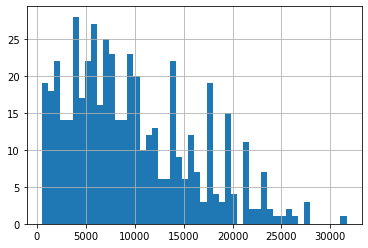

In [49]:
gain_per_month['sum'].hist(bins=50)

Суммарный вклад пользователе за год смещен в сторону значений меньше 12 тысячь, это значит, что большое количество пользователей либо подключилось после половины года, либо предпочитают недорогой тариф.  

## Проанализируем данные.  

Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

Разобьём всех пользователей на группы по тарифам.

In [50]:
tariffs_df

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [51]:
smart_users = users_df.query('tariff == "smart"')['user_id']
ultra_users = users_df.query('tariff == "ultra"')['user_id']
smart_users

1      1001
2      1002
5      1005
6      1006
7      1007
       ... 
494    1494
496    1496
497    1497
498    1498
499    1499
Name: user_id, Length: 351, dtype: int64

### Сообщения  
Изучим использование смс абонентами с разными тарифами.
#### Тариф Смарт

In [52]:
mess_smart_desc = messages_per_month.query('user_id in @smart_users').describe().astype('int')

mess_smart_desc

,jan,feb,mar,apr,may,jun,jul,aug,sep,okt,nov,dec,sum
count,302,302,302,302,302,302,302,302,302,302,302,302,302
mean,2,4,8,11,15,18,22,26,28,32,35,40,246
std,7,13,19,21,24,26,28,29,28,28,28,29,222
min,0,0,0,0,0,0,0,0,0,0,0,0,1
25%,0,0,0,0,0,0,0,0,0,8,13,16,75
50%,0,0,0,0,0,0,9,17,22,28,29,35,180
75%,0,0,0,16,27,30,40,42,48,50,54,58,358
max,74,85,110,105,103,134,137,134,136,139,124,143,1092


Абоненты, использующие тариф Смарт, в среденем отправляют 40 сообщений, если в принципе их используют. Я взял именно это значение, потому что только к концу года пользователей стало много, т.е. среднее выборки ближе к математическому ожиданию.  

Построим гисторгамму.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdf8b3ddd10>,
      dtype=object)

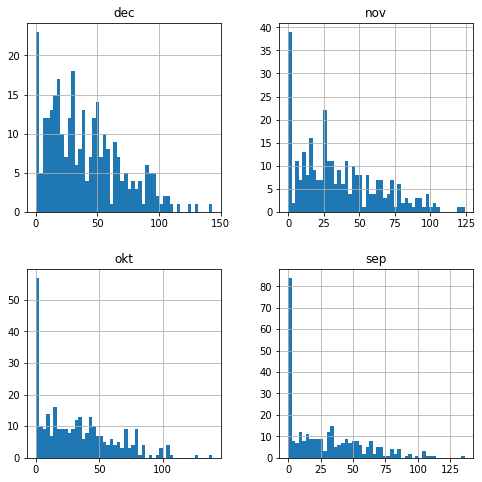

In [53]:
messages_per_month.query('user_id in @smart_users')[['sep','okt','nov','dec']].hist(bins=50,figsize=(8,8))

Основные характеристики по месяцам(среднее количество, дисперсию и стандартное отклонение):

In [54]:
mess_smart_desc.loc['var'] = mess_smart_desc.loc['std'] **2

mess_smart_desc.loc[['mean','var','std']]

,jan,feb,mar,apr,may,jun,jul,aug,sep,okt,nov,dec,sum
mean,2,4,8,11,15,18,22,26,28,32,35,40,246
var,49,169,361,441,576,676,784,841,784,784,784,841,49284
std,7,13,19,21,24,26,28,29,28,28,28,29,222


Определим, с какой вероятностью абонентам тарифа Ультра хватает смс. 
Построим стандартное распределение.

Посчитаем также вероятность напрямую и сравним сос стандартным распеределнием.

In [55]:
mess_to50_s_prob =len(
    messages_per_month.query('user_id in @smart_users and dec < 50')['dec']
)/len(
    messages_per_month.query('user_id in @smart_users')['dec']
)#прямой расчет

In [56]:
round(mess_to50_s_prob,3)#прямой расчет

0.666

In [57]:
mess_s_distr = st.norm(40,29)

In [58]:
(mess_s_distr.cdf(50)).round(3)#нормальное распределение

0.635

In [59]:
mess_more68_s_prob =len(
    messages_per_month.query('user_id in @smart_users and dec > 68')['dec']
)/len(
    messages_per_month.query('user_id in @smart_users')['dec']
)

In [60]:
mess_more68_s_prob#прямой расчет

0.17218543046357615

In [61]:
(1 - mess_s_distr.cdf(68)).round(3)#нормальное распределение

0.167

Только примерно 65% абонентов из выборки хватает смс, если они их используют. Это значит, очень большой части пользователей не хватает смс. Дополнительные смс стоят по 3 рубля, около 17% пользоватлей переплачивают только за смс больше 55 рублей, 10% от стоимости тарифа, что является существенной тратой.

In [62]:
(mess_s_distr.cdf(65)).round(3)

0.806

In [63]:
(1 - mess_s_distr.cdf(83) ).round(3)

0.069

Если увеличить количество смс до 65, то более 70% пользователей будут полностью удовлетворены, при этом только 15% существенно не будет хватать смс.

#### Тариф Ультра

In [64]:
mess_ultra_desc = messages_per_month.query('user_id in @ultra_users').describe().astype('int')

mess_ultra_desc

,jan,feb,mar,apr,may,jun,jul,aug,sep,okt,nov,dec,sum
count,124,124,124,124,124,124,124,124,124,124,124,124,124
mean,2,4,9,14,20,28,36,41,48,57,60,67,392
std,11,14,26,29,35,41,47,46,46,51,49,50,333
min,0,0,0,0,0,0,0,0,0,0,0,0,8
25%,0,0,0,0,0,0,0,0,3,9,17,29,149
50%,0,0,0,0,0,6,19,26,36,47,49,55,295
75%,0,0,0,10,27,40,58,70,81,94,89,97,521
max,75,90,155,143,148,201,211,180,188,223,197,224,1463


Абоненты, использующие тариф Ультра, в среденем отправляют 60 сообщений, если в принципе их используют. Я взял именно это значение, потому что только к концу года пользователей стало достаточно. А в декабре среднее значение могло сильно измениться из-за тех, кто отправил много смс на Новый год. Тариф включает в себя 1000 смс. Даже самые активные абоненты не выходят за лимит.

Посторим гистрограмму и  определим основные характеристики по месяцам(среднее количество, дисперсию и стандартное отклонение):

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdf8b0ac050>,
      dtype=object)

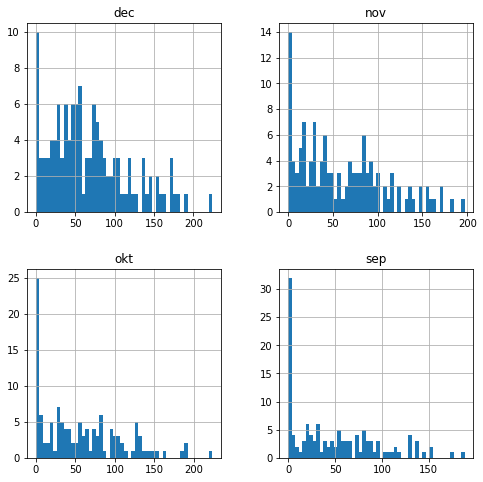

In [65]:
messages_per_month.query('user_id in @ultra_users')[['sep','okt','nov','dec']].hist(bins=50,figsize=(8,8))

In [66]:
mess_ultra_desc.loc['var'] = mess_ultra_desc.loc['std'] **2

mess_ultra_desc.loc[['mean','var','std']]

,jan,feb,mar,apr,may,jun,jul,aug,sep,okt,nov,dec,sum
mean,2,4,9,14,20,28,36,41,48,57,60,67,392
var,121,196,676,841,1225,1681,2209,2116,2116,2601,2401,2500,110889
std,11,14,26,29,35,41,47,46,46,51,49,50,333


In [67]:
mess_u_distr = st.norm(60,49)

In [68]:
1 - mess_u_distr.cdf(200)

0.002137366980086264

Даже если уменьшить количество смс до 200, то всем абонентам должно хватать. 

### Интеренет  
Изучим использование интернета абонентами с разными тарифами.  

#### Тарифа Смарт.

In [69]:
mb_smart_desc = mb_per_month.query('user_id in @smart_users').describe().astype('int')

mb_smart_desc

,jan,feb,mar,apr,may,jun,jul,aug,sep,okt,nov,dec,sum
count,350,350,350,350,350,350,350,350,350,350,350,350,350
mean,868,2004,3428,4458,6541,7647,9330,11480,12457,14479,15690,17931,106320
std,3308,5157,7016,7267,8833,9065,9205,9248,8605,8301,7217,6515,61640
min,0,0,0,0,0,0,0,0,0,0,0,0,12288
25%,0,0,0,0,0,0,0,0,0,10240,12288,14336,53504
50%,0,0,0,0,0,0,9216,14336,14336,16384,16384,17408,101376
75%,0,0,0,9216,15360,16384,17408,18432,19456,20480,20480,21504,147456
max,24576,28672,25600,27648,30720,34816,29696,31744,31744,32768,36864,38912,276480


Судя по медиане, многим не достаточно 15360 мб, входящих в тариф.

Построим гисторграмму и определим основные характеристики по месяцам(среднее количество, дисперсию и стандартное отклонение):

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdf8b01d7d0>,
      dtype=object)

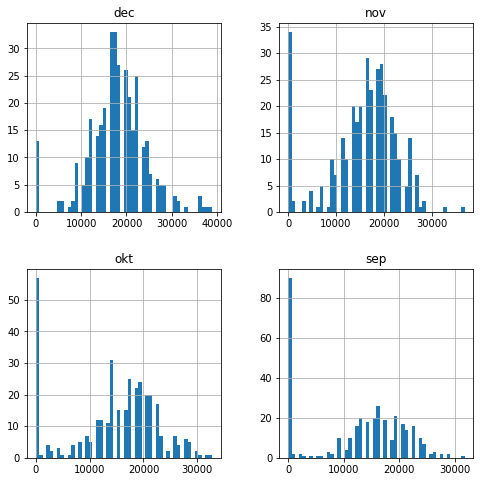

In [70]:
mb_per_month.query('user_id in @smart_users')[['sep','okt','nov','dec']].hist(bins=50,figsize=(8,8))

In [71]:
mb_smart_desc.loc['var'] = mb_smart_desc.loc['std'] **2

mb_smart_desc.loc[['mean','var','std']]

,jan,feb,mar,apr,may,jun,jul,aug,sep,okt,nov,dec,sum
mean,868,2004,3428,4458,6541,7647,9330,11480,12457,14479,15690,17931,106320
var,10942864,26594649,49224256,52809289,78021889,82174225,84732025,85525504,74046025,68906601,52085089,42445225,3799489600
std,3308,5157,7016,7267,8833,9065,9205,9248,8605,8301,7217,6515,61640


По мере увеличения количества абонентов, нулевое использование мб уменьшается. Отбросим эти значения и построим нормальное распределение.

In [72]:
mb_smart_more_0 = mb_per_month.query('user_id in @smart_users and dec > 0')['dec'].describe().astype('int')

mb_smart_more_0

count      337
mean     18623
std       5583
min       5120
25%      15360
50%      18432
75%      22528
max      38912
Name: dec, dtype: int64

In [73]:
mb_s_distr = st.norm(mb_smart_more_0['mean'],mb_smart_more_0['std'])#нормальное распределение

In [74]:
mb_s_distr.cdf(15360) 

0.27945785503761167

In [75]:
mb_s_distr.cdf(15360 + 2 * 1024) -  mb_s_distr.cdf(15360) 

0.13440282319571512

In [76]:
1 - mb_s_distr.cdf(15360 + 2 * 1024)

0.5861393217666733

Только 30% абонентов хватает предоставленных мб. Почти 14% вынуждены дополнительно покупать 1 или 2 гб, что составляет 36% и 72% от цены самого тарифа соответсвенно. Больше половины абонентов вынуждены переплачивать за интенет цену, больше стоимости тарифа, от 600 рублей, что может спровоцировать людей перейти на другой тариф. 

#### Тариф Ультра.

In [77]:
mb_ultra_desc = mb_per_month.query('user_id in @ultra_users').describe().astype('int')

mb_ultra_desc

,jan,feb,mar,apr,may,jun,jul,aug,sep,okt,nov,dec,sum
count,147,147,147,147,147,147,147,147,147,147,147,147,147
mean,815,1985,4451,6359,8986,10964,12838,14503,15241,16927,18327,20842,132242
std,3555,6164,9385,10058,11901,11770,12759,12584,11553,11566,11011,11176,87559
min,0,0,0,0,0,0,0,0,0,0,0,0,5120
25%,0,0,0,0,0,0,0,0,3072,6656,10240,13312,64512
50%,0,0,0,0,0,9216,12288,14336,15360,17408,17408,21504,112640
75%,0,0,1536,11264,17408,20480,21504,24064,23552,24576,25600,27648,178688
max,19456,32768,35840,35840,44032,40960,44032,49152,43008,47104,45056,44032,376832


Судя по третьему квартелю, большинству пользователей хватает заложенных в тариф мегабайт, 30720.

Построим гисторграмму и определим основные характеристики по месяцам(среднее количество, дисперсию и стандартное отклонение):

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe019bb13d0>,
      dtype=object)

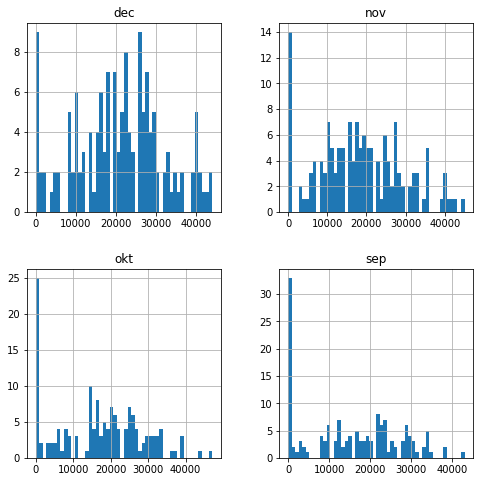

In [78]:
mb_per_month.query('user_id in @ultra_users')[['sep','okt','nov','dec']].hist(bins=50,figsize=(8,8))

In [79]:
mb_ultra_desc.loc['var'] = mb_ultra_desc.loc['std'] **2

mb_ultra_desc.loc[['mean','var','std']]

,jan,feb,mar,apr,may,jun,jul,aug,sep,okt,nov,dec,sum
mean,815,1985,4451,6359,8986,10964,12838,14503,15241,16927,18327,20842,132242
var,12638025,37994896,88078225,101163364,141633801,138532900,162792081,158357056,133471809,133772356,121242121,124902976,7666578481
std,3555,6164,9385,10058,11901,11770,12759,12584,11553,11566,11011,11176,87559


Строим нормальное распределение, аналогично с тарифом Смарт.

In [80]:
mb_ultra_more_0 = mb_per_month.query('user_id in @ultra_users and dec > 0')['dec'].describe().astype('int')

mb_ultra_more_0

count      138
mean     22201
std      10135
min       1024
25%      15360
50%      22528
75%      28416
max      44032
Name: dec, dtype: int64

In [81]:
mb_u_distr = st.norm(mb_ultra_more_0['mean'],mb_ultra_more_0['std'])#нормальное распределение

In [82]:
mb_u_distr.cdf(30720) 

0.7997006721553563

In [83]:
1 - mb_u_distr.cdf(30720 + 1024) 

0.17320166591310082

80% клиентов должно хватать 30 Гб, 16% докупают больше 1 Гб.

### Звонки  
Изучим звонки абонентами с разными тарифами.

#### Тариф Смарт.

In [84]:
minut_smart_desc = minute_per_month.query('user_id in @smart_users').describe().astype('int')

minut_smart_desc

,jan,feb,mar,apr,may,jun,jul,aug,sep,okt,nov,dec,sum
count,349,349,349,349,349,349,349,349,349,349,349,349,349
mean,18,46,80,109,146,173,219,265,297,334,365,430,2488
std,72,127,173,187,209,215,227,233,228,216,196,199,1626
min,0,0,0,0,0,0,0,0,0,0,0,0,133
25%,0,0,0,0,0,0,0,0,0,187,243,301,1220
50%,0,0,0,0,0,0,172,282,322,340,380,425,2169
75%,0,0,0,195,328,369,429,459,479,486,500,553,3583
max,503,711,783,744,784,795,778,917,797,956,877,1355,7950


Судя по среднему и медиане, большинству хватает 500 минут, но те, которым не хватает, очень много докупают.

Построим гисторграмму и определим основные характеристики по месяцам(среднее количество, дисперсию и стандартное отклонение):

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdf8a39d9d0>,
      dtype=object)

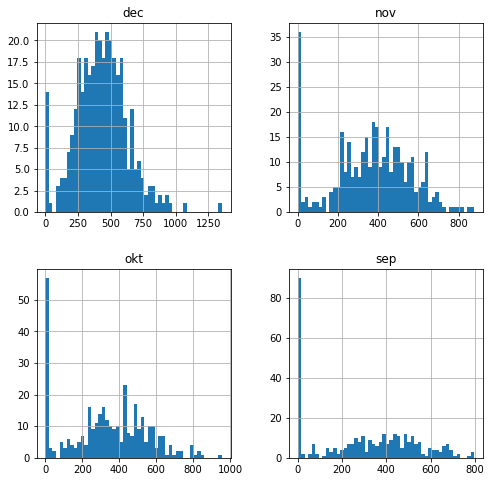

In [85]:
minute_per_month.query('user_id in @smart_users')[['sep','okt','nov','dec']].hist(bins=50,figsize=(8,8))

In [86]:
minut_smart_desc.loc['var'] = minut_smart_desc.loc['std'] **2

minut_smart_desc.loc[['mean','var','std']]

,jan,feb,mar,apr,may,jun,jul,aug,sep,okt,nov,dec,sum
mean,18,46,80,109,146,173,219,265,297,334,365,430,2488
var,5184,16129,29929,34969,43681,46225,51529,54289,51984,46656,38416,39601,2643876
std,72,127,173,187,209,215,227,233,228,216,196,199,1626


В декабре данные сильно отличаются от остальных месяцев, возможно это связано с Новым годом.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdf89fc8190>,
      dtype=object)

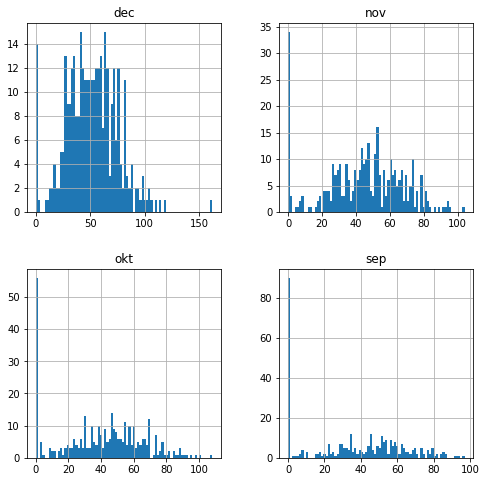

In [87]:
calls_count_per_month.query('user_id in @smart_users')[['sep','okt','nov','dec']].hist(bins=80,figsize=(8,8))

Действительно, в декабре больше звонили, построим рапределение для ноября, чтобы иметь более точную картину. 

In [88]:
min_smart_more_0 = minute_per_month.query('user_id in @smart_users and nov > 0')['nov'].describe().astype('int')

min_smart_more_0

count    315
mean     405
std      163
min       11
25%      289
50%      397
75%      510
max      877
Name: nov, dtype: int64

In [89]:
min_s_distr = st.norm(min_smart_more_0['mean'],min_smart_more_0['std'])#нормальное распределение

In [90]:
min_s_distr.cdf(500)

0.7199934622725455

In [91]:
1 - min_s_distr.cdf(500+18)

0.24407585636342133

In [92]:
min_s_distr.cdf(500+50)

0.8131517378860882

72% клиентов хватает 500 минут для разговоров, но более 24% вынуждены переплачивать за дополнительные минуты больше 10% от стоимости тарифа. Если увеличить количество минут на 50, то, вероятно, до 80% клиентов будут удовлетворены.

#### Тариф Ультра.

In [93]:
minut_ultra_desc = minute_per_month.query('user_id in @ultra_users').describe().astype('int')

minut_ultra_desc

,jan,feb,mar,apr,may,jun,jul,aug,sep,okt,nov,dec,sum
count,143,143,143,143,143,143,143,143,143,143,143,143,143
mean,25,47,117,162,222,262,324,357,403,447,471,538,3379
std,115,154,254,255,300,307,334,327,336,335,305,326,2463
min,0,0,0,0,0,0,0,0,0,0,0,0,65
25%,0,0,0,0,0,0,0,0,36,156,233,279,1158
50%,0,0,0,0,0,127,251,346,393,427,488,548,3025
75%,0,0,81,294,451,480,617,594,686,696,650,758,4774
max,817,872,1504,1037,1130,1338,1206,1249,1171,1300,1161,1476,11994


Абсолютно всем абонентам этого тарифа хватает минут. Причем количество использованных минут не сильно отличается от тарифа Смарт. 

Построим гисторграмму и определим основные характеристики по месяцам(среднее количество, дисперсию и стандартное отклонение):

In [94]:
minut_ultra_desc.loc['var'] = minut_ultra_desc.loc['std'] **2

minut_ultra_desc.loc[['mean','var','std']]

,jan,feb,mar,apr,may,jun,jul,aug,sep,okt,nov,dec,sum
mean,25,47,117,162,222,262,324,357,403,447,471,538,3379
var,13225,23716,64516,65025,90000,94249,111556,106929,112896,112225,93025,106276,6066369
std,115,154,254,255,300,307,334,327,336,335,305,326,2463


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdf899a0850>,
      dtype=object)

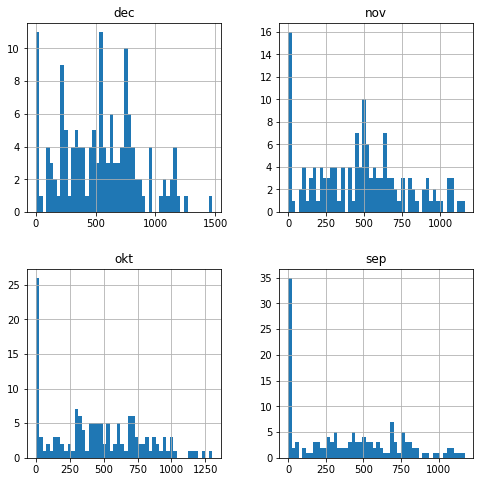

In [95]:
minute_per_month.query('user_id in @ultra_users')[['sep','okt','nov','dec']].hist(bins=50,figsize=(8,8))

Для разных месяцев данные рапределены примерно одинаково, но в декабре люди чаще звонили, что увеличило выборку звонящих, но доббавило длинный хвост больших значений. Построим нормальное распределение по ноябрю и для значений больше 0, так как по месяцам заметна тенденция уменьшения нулевых значений.

In [96]:
min_ultra_more_0 = minute_per_month.query('user_id in @ultra_users and nov > 0')['nov'].describe().astype('int')

min_ultra_more_0

count     129
mean      522
std       277
min         6
25%       310
50%       506
75%       683
max      1161
Name: nov, dtype: int64

In [97]:
min_u_distr = st.norm(min_ultra_more_0['mean'],min_ultra_more_0['std'])#нормальное распределение

In [98]:
min_u_distr.cdf(1000)

0.9577931598988465

Даже если уменьшить количество минут до 1000, то 95% абонентов будет этого хватать, если распределение не сдвинется. 

### Общие расходы пользователей

Рассмотрим, как распределятся расходы пользователей по тарифам. 

#### Тариф Смарт.

Построим гистограмму для расходов пользователей по месяцам и сумарным расходам за год.

In [99]:
gain_per_month

,user_id,tariff,jan,feb,mar,apr,may,jun,jul,aug,sep,okt,nov,dec,sum
0,1000,ultra,0.0,0.0,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,15600.0
1,1001,smart,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1150.0,550.0,1700.0
2,1002,smart,0.0,0.0,0.0,0.0,0.0,550.0,1150.0,1550.0,950.0,550.0,1350.0,1150.0,7250.0
3,1003,ultra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.0,9750.0
4,1004,ultra,0.0,0.0,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,15600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495,ultra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1950.0,2400.0,1950.0,3300.0,1950.0,11550.0
496,1496,smart,550.0,3336.0,2616.0,1750.0,2350.0,1640.0,2503.0,2150.0,2950.0,3150.0,2952.0,1753.0,27700.0
497,1497,smart,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,550.0,550.0,1598.0,2698.0
498,1498,smart,0.0,0.0,0.0,0.0,0.0,0.0,550.0,2386.0,1950.0,1750.0,0.0,0.0,6636.0


In [123]:
gain_smart = gain_per_month.query('tariff == "smart"')['jan']
for i in ['feb','mar','apr','may','jun','jul','aug','sep','okt','nov','dec']:
    gain_smart = gain_smart.append(gain_per_month.query('tariff == "smart"')[i])

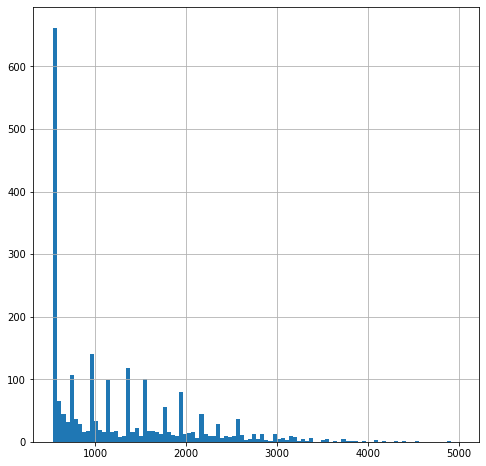

In [101]:
gain_smart.hist(bins=100,figsize=(8,8),range=(540,5000))

По гистограмме видно, что пользователи достаточно часто укладываются в тариф. Малые пики появились от того, что люди часто допокупают Гб. 

Гистограмма суммарных расходов:

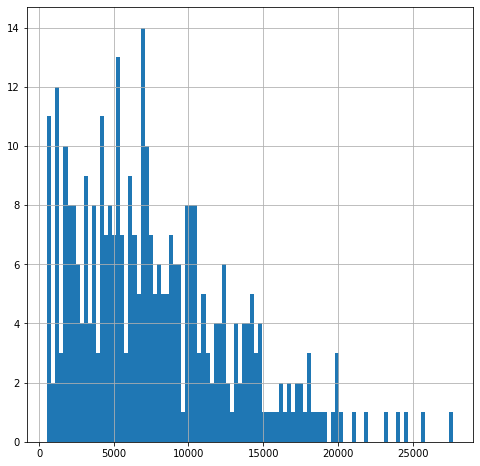

In [102]:
gain_per_month.query('tariff == "smart"')['sum'].hist(bins=100,figsize=(8,8))

Гистограмма суммарных расходов имеет такой вид, потому что клиенты подключались к тарифу постепенно в течение года. Постепенно она будет стремиться к нормальной.

Основные сведения для разных месяцев.

In [103]:
gain_per_month.query('tariff == "smart"').describe().astype('int')

,user_id,jan,feb,mar,apr,may,jun,jul,aug,sep,okt,nov,dec,sum
count,351,351,351,351,351,351,351,351,351,351,351,351,351,351
mean,1244,69,133,247,298,466,546,678,853,895,1104,1164,1461,7920
std,144,251,367,563,533,725,768,803,868,811,893,828,1024,5250
min,1001,0,0,0,0,0,0,0,0,0,0,0,0,550
25%,1120,0,0,0,0,0,0,0,0,0,550,550,728,4073
50%,1236,0,0,0,0,0,0,550,562,640,898,975,1150,6950
75%,1371,0,0,0,550,617,837,1033,1350,1374,1555,1578,1950,10819
max,1499,2350,3336,2616,2950,3550,4389,3350,4295,3759,4090,5560,6536,27700


#### Тариф Ультра.

Построим гистограмму для расходов пользователей по месяцам и сумарным расходам за год.

In [104]:
gain_ultra = gain_per_month.query('tariff == "ultra"')['jan']
for i in ['feb','mar','apr','may','jun','jul','aug','sep','okt','nov','dec']:
    gain_ultra = gain_ultra.append(gain_per_month.query('tariff == "ultra"')[i])

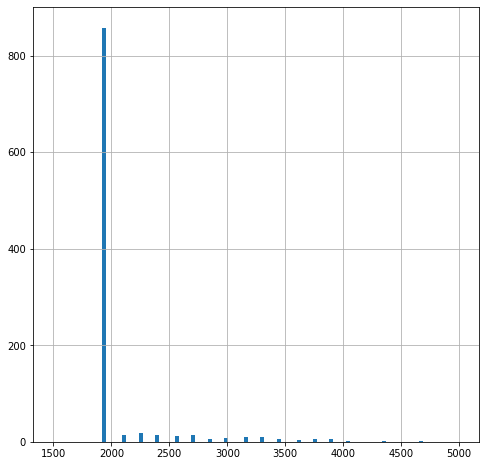

In [105]:
gain_ultra.hist(bins=100,figsize=(8,8),range=(1500,5000))

По единичным пикам гистограмма распределения абонентской платы по месяцам можно сделать вывод, что практически всем хватает пакета минут, смс и мб. Чаще всего докупают Гб.

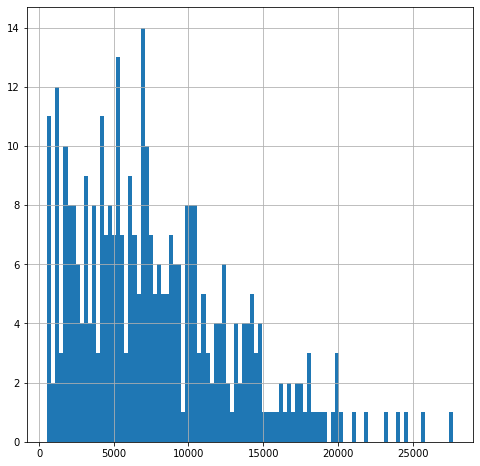

In [106]:
gain_per_month.query('tariff == "smart"')['sum'].hist(bins=100,figsize=(8,8))

По мере увеличения абонентов гистограмма примет вид нормальной с очень малым стандартным отклонением.

Даже если бы количество минут уменьшили до 1000, то 95% пользователей скорее всего хватало бы их.

## Проверка гипотез  

Нам необходимо проверить 2 гипотезы:
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

### Средняя выручка от тарифов «Ультра» и «Смарт» различается  

Сформулируем гипротезы:  
Нулевая - выручка тарифов Ультра и Смарт в среднем для абонентов совпадает.   
Альтернативная - выручка тарифов Ультра и Смарт в среднем для абонентов различаются.

Ранее мы посчитали выручку для каждого пользователя по месяцам. Посмотрим суммарный вклад для каждого тарифа и проверим существенность разницы значений.

Выделим ненулевые значения, так как именно они показывают активность клиентов.

In [115]:
gain_smart[gain_smart > 0].describe().astype('int')

count    2230
mean     1246
std       794
min       550
25%       550
50%       950
75%      1690
max      6536
dtype: int64

In [114]:
gain_ultra[gain_ultra > 0 ].describe().astype('int')

count     986
mean     2061
std       356
min      1950
25%      1950
50%      1950
75%      1950
max      4650
dtype: int64

Стандартное отклонение тарифов различаются в два раза, значит при проведении проверки гипотезы на равенство среднего укажем, что дисперсия генеральных совокупностей отличается. Установим уровень значимости в 5%.

In [116]:
st.ttest_ind(
    gain_smart[gain_smart > 0],gain_ultra[gain_ultra > 0 ],equal_var=False
).pvalue

6.949427818333632e-286

Судя по тесту на равенство среднего двух совокупностей, средняя выручка пользователей тарифов «Ультра» и «Смарт» вероятнее всего различается. Значит мы должны склониться к альтернативной гипотезе.

Средняя выручка за 2018 год от тарифа Смарт составила 7537 с пользователя, средняя выручка от тарифа Ультра 13575. Разница почти в два раза. Хотя суммарная выручка от тарифов Смарт и Ультра составила 2млн 645тыс и 2млн 22тыс соответсвенно. 

### Выручка пользователей из Москвы отличается  

Сформулируем гипротезы:  
Нулевая - средняя от выручка пользователей из Москвы и средняя выручка от пользователей из регионов совпадают.   
Альтернативная -  средняя от выручка пользователей из Москвы и средняя выручка от пользователей из регионов различаются.  

Составим списки абонентов из Москвы и из других регионов. Проверим нулевую гипотезу.

In [124]:
Moscow_users = users_df.query('city	 == "Москва"')['user_id']

In [125]:
Moscow_gain = gain_per_month.query('user_id in @Moscow_users')['jan']
for i in ['feb','mar','apr','may','jun','jul','aug','sep','okt','nov','dec']:
    Moscow_gain = Moscow_gain.append(gain_per_month.query('user_id in @Moscow_users')[i])

other_gain = gain_per_month.query('user_id not in @Moscow_users')['jan']
for i in ['feb','mar','apr','may','jun','jul','aug','sep','okt','nov','dec']:
    other_gain = other_gain.append(gain_per_month.query('user_id not in @Moscow_users')[i])

In [132]:
Moscow_gain[Moscow_gain > 0].describe().astype('int')

count     611
mean     1515
std       744
min       550
25%       750
50%      1750
75%      1950
max      5111
dtype: int64

In [135]:
other_gain[other_gain > 0].describe().astype('int')

count    2605
mean     1491
std       795
min       550
25%       706
50%      1550
75%      1950
max      6536
dtype: int64

В среднем за месяц пользователи из регионов приносят по 1491, а пользователи из Москвы по 1515. Скорее всего среднее этих совокупностей совпадает. Проведем проверку гипотезы математическими методами.  
Стандартное отклонение тарифов слабо различаются, значит при проведении проверки гипотезы на равенство среднего укажем, что дисперсии генеральных совокупностей одинаковые. Установим уровень значимости в 5%.

In [138]:
st.ttest_ind(Moscow_gain[Moscow_gain > 0],other_gain[other_gain > 0]).pvalue

0.5046617559882919

Очень вероятно, что клиенты из Москвы в среднем приносят примерно столько же денег, как и клиенты из других регионов. Так как  вероятность совпадения средних близка к 50%. Мы принимаем нулевую гипотезу.


## Общий вывод  

После анализа данных о тарифах Смарт и Ультра можно сделать вывод, что они приносят существенно разную прибыль.
Если случайная выборка репрезентативна, то клиентов, использующих тариф Смарт на данный момент в несколько раз больше, чем использующих тариф Ультра.

In [ ]:
pd.DataFrame(
    data=[users_df.query('tariff == "ultra"')['tariff'].count(),users_df.query('tariff == "smart"')['tariff'].count()],
    index=['Ультра','Смарт']
).plot.pie(subplots=True)

При этом, средняя выручка за 2018 год от тарифа Смарт составила 7537 с клиента, средняя выручка от тарифа Ультра 13575. Разница почти в два раза. Хотя суммарная выручка от тарифа Смарт больше на 600 тысячь за счет количества абонентов. 
Также многие абоненты тарифа Смарт могут быть неудовлетворены тарифом, потому что:

- Только 55% абонентов из выборки хватает смс, если они их используют. Это значит, очень большой части пользователей не хватает смс. Дополнительные смс стоят по 3 рубля, около 25% пользоватлей переплачивают только за смс больше 55 рублей, 10% от стоимости тарифа, что является существенной тратой.
- Только 30% абонентов хватает предоставленных мб. Почти 14% вынуждены дополнительно покупать 1 или 2 гб, что составляет 36% и 72% от цены самого тарифа соответсвенно. Больше половины абонентов вынуждены переплачивать за интенет цену, больше стоимости тарифа, от 600 рублей, что может спровоцировать людей перейти на другой тариф.
- 72% клиентов хватает 500 минут для разговоров, но более 24% вынуждены переплачивать за дополнительные минуты больше 10% от стоимости тарифа. Если увеличить количество минут на 50, то, вероятно, до 80% клиентов будут удовлетворены. 

Эти выводы сделаны по выборкам последних месяцев 2018 года, так как в начале 2018 абонентов было недостаточно. Их возможно нужно проверить для более свежих данных. Если они подтвердятся, то тариф Смарт требует существенной доработки. 

В тарифе Ультра наоборот все потребности абонетов удовлетворены:

- Даже если уменьшить количество смс до 200, то почти 90% абонентов должно хватать, если полагаться на нормальное распределение. Хотя, если судить по нашей выборке, лишь единицам не хватает 200 смс.
- 80% клиентов должно хватать 30 Гб, 16% докупают больше 1 Гб.
- Даже если бы количество минут уменьшили до 1000, то 95% пользователей скорее всего хватало бы их.